# Schematics
Below, I create some schematics to help understand the theory for how temperature distribution changes with warming.

In [12]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, dry_profile_pressure, lapse_moist, lapse_dry
from isca_tools.utils.constants import L_v, c_p, g, R
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms, get_temp_adiabat
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [2]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
# Get surface and free tropospheric pressure values in Pa.
pressure_ft_approx = 500        # approximate pressure of free troposphere in hPa
exp_dir = 'tau_sweep/aquaplanet/depth=1/k=1/'
pressure_surface, pressure_ft = isca_tools.load_dataset(exp_dir).pfull.sel(pfull=[np.inf, pressure_ft_approx], method='nearest').to_numpy() * 100

## Theory Terms
Below I plot a schematic for each term in the new formula - 4 in total.
For each, I isolate the effect of one contribution.

In [4]:
pressure_schematic = np.linspace(400*100, pressure_surface, 100)

def get_temp_surf_from_temp_adiabat(temp_adiabat, r_surface = None, pressure_surface=pressure_surface, pressure_ft=pressure_ft, 
                                    guess_temp_surf=280):
    def fit_func(temp_surf):
        temp_lcl = lcl_temp_bolton(temp_surf, r_surface*100)
        return convection_neutral_profile(float(temp_surf), pressure_surface, float(temp_lcl), np.array([pressure_ft])) - temp_adiabat
    return float(scipy.optimize.fsolve(fit_func, guess_temp_surf))

def schematic_plot(temp_cold, sphum_cold, temp_adiabat_change_cold, r_change_cold = 0, 
                   temp_hot = None, sphum_hot = None, temp_adiabat_change_hot = None, r_change_hot=0, 
                   pressure_surface = pressure_surface, pressure_ft=pressure_ft, 
                   pressure_levels=pressure_schematic, include_diff_plot = False):
    """
    Method to plot schematic showing how the temperature profile of a cold (blue) and hot (red) day changes under warming, with given 
    constraints. Idea is to isolate each term in equation for change in surface temperature.
    
    Args:
        temp_cold: float
            Surface temperature of cold day in reference climate [K].
        sphum_cold: float
            Surface specific humidity of cold day in reference climate [kg/kg].
        temp_adiabat_change_cold: float
            Change of adiabatic temperature of cold day at `pressure_ft` with warming [K].
        r_change_cold: float
            Change of surface relative humidity of cold day with warming.
        temp_hot: float
            Surface temperature of hot day in reference climate [K]. If not given, set to `temp_cold`.
        sphum_hot: float
            Surface specific humidity of hot day in reference climate [K]. If not given, set to `sphum_cold`.
        temp_adiabat_change_hot: float
            Change of adiabatic temperature of hot day at `pressure_ft` with warming [K]. If not given, set to `temp_adiabat_change_cold`.
        r_change_hot: float
            Change of surface relative humidity of hot day with warming.
        pressure_surface: float
            Near-surface pressure [hPa].
        pressure_ft: float
            Free tropospheric pressure [hPa]
        pressure_levels: float [n_levels]
            Pressure levels to plot temperature profile at.
        include_diff_plot: bool
            If `True`, the figure will have a second axis, plotting the temperature profile anomaly for each climate. 
            I.e. red - blue line for each climate.
    """
    n_climates = 2      # function assumes there are two climates and a cold and hot day (as indicated by dict) in both.
    temp_surf = {'cold': np.zeros(n_climates), 'hot': np.zeros(n_climates)}
    rh = {'cold': np.zeros(n_climates), 'hot': np.zeros(n_climates)}
    temp_lcl = {'cold': np.zeros(n_climates), 'hot': np.zeros(n_climates)}
    pressure_lcl = {'cold': np.zeros(n_climates), 'hot': np.zeros(n_climates)}
    temp_adiabat = {'cold': np.zeros(n_climates), 'hot': np.zeros(n_climates)}
    temp_profile = {'cold': np.zeros((n_climates, len(pressure_levels))), 'hot': np.zeros((n_climates, len(pressure_levels)))}
    
    temp_surf['cold'][0] = temp_cold
    temp_surf['hot'][0] = temp_cold if temp_hot is None else temp_hot
    rh['cold'][0] = sphum_cold / sphum_sat(temp_cold, pressure_surface) 
    rh['hot'][0] = (sphum_cold if sphum_hot is None else sphum_hot) / sphum_sat(temp_surf['hot'][0], pressure_surface) 
    for key in temp_surf:
        temp_lcl[key][0] = lcl_temp_bolton(temp_surf[key][0], rh[key][0] * 100)
        temp_adiabat[key][0] = float(convection_neutral_profile(temp_surf[key][0], pressure_surface, temp_lcl[key][0], np.array([pressure_ft])))
    
    # Shift to warmer climate
    if temp_adiabat_change_hot is None:
        temp_adiabat_change_hot = temp_adiabat_change_cold
    temp_adiabat_change = {'cold': temp_adiabat_change_cold, 'hot': temp_adiabat_change_hot}
    rh_change = {'cold': r_change_cold, 'hot': r_change_hot}
    for key in temp_surf:
        rh[key][1] = rh[key][0] + rh_change[key]
        temp_adiabat[key][1] = temp_adiabat[key][0] + temp_adiabat_change[key]
        temp_surf[key][1] = get_temp_surf_from_temp_adiabat(temp_adiabat[key][1], rh[key][1])
        temp_lcl[key][1] = lcl_temp_bolton(temp_surf[key][1], rh[key][1]*100)
        for i in range(n_climates):
            temp_profile[key][i] = convection_neutral_profile(temp_surf[key][i], pressure_surface, temp_lcl[key][i], pressure_schematic)
            pressure_lcl[key][i] = dry_profile_pressure(temp_surf[key][i], pressure_surface, temp_lcl[key][i])
    
    # Plot profiles
    colors_day = {'cold': 'b', 'hot': 'r'}
    linestyles_climate = ['-', '--']
    if include_diff_plot:
        fig, ax = plt.subplots(1,2, figsize=(2*width['one_col'], width['one_col']/ar), sharey=True)
    else:
        fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharey=True)
        ax = [ax]
    for i in range(n_climates):
        for key in temp_surf:
            ax[0].plot(temp_profile[key][i], pressure_schematic/100, color=colors_day[key], linestyle=linestyles_climate[i])
            for j in range(len(ax)):
                ax[j].axhline(pressure_lcl[key][i]/100, color=colors_day[key], linestyle=linestyles_climate[i], lw=ax_linewidth)
        if include_diff_plot:
            ax[1].plot(temp_profile['hot'][i]-temp_profile['cold'][i], pressure_schematic/100, linestyle=linestyles_climate[i], color='k')
    for j in range(len(ax)):
        ax[j].axhline(pressure_ft/100, color='k', lw=ax_linewidth)
    ax[0].invert_yaxis()
    ax[0].set_ylim(np.round(pressure_levels[-1]/100, -2), pressure_levels[0]/100)
    ax[0].set_xlabel('Temperature [K]')
    ax[0].set_ylabel('Pressure [hPa]')
    if include_diff_plot:
        ax[1].set_xlabel('Temperature Anomaly, $\Delta T$ [K]')
    return fig, ax

### Hot Get Hotter
Between 900hPa and 750hPa, the two days follow a different lapse rate - this is the crucial effect, not the changing of the LCL.

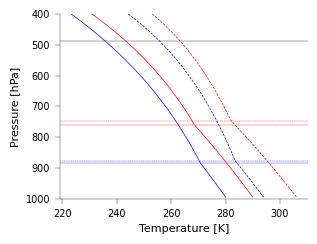

In [5]:
# Hot get hotter - red line has higher temperature in ref climate
q_schematic = 0.3 * sphum_sat(290, pressure_surface) 
temp_a_change_schematic = 20
fig, ax = schematic_plot(temp_cold=280, sphum_cold=q_schematic, temp_adiabat_change_cold=temp_a_change_schematic, 
                         temp_hot=290, include_diff_plot=False)

### Drier Get Hotter
Below we see the amplified warming of dry days.

In the theory, there are two contributions: one positive and one negative. In the schematic we can see these two effects:
* Amplified warming of dry days: If drier, then LCL is at higher altitude so have region where dry days follow dry adiabat but moist days follow moist adiabat. It is this lapse rate differential than is crucial.
* Suppressed warming of dry days: If drier, temperature in free troposphere is lower. So moist adiabatic lapse rate is closer to dry adiabatic lapse rate than it is for moist days. This means the lapse rate differential is smaller on dry days than it is on moist days.

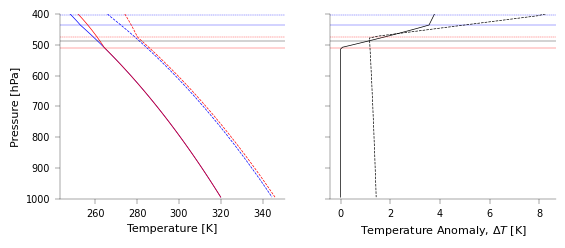

In [75]:
save_dry_hotter_fig = True
# fig, ax = schematic_plot(temp_cold=280, sphum_cold=q_schematic * 0.5, temp_adiabat_change_cold=temp_a_change_schematic, 
#                          sphum_hot=q_schematic*1.1, include_diff_plot=False)        # dry get hotter

fig, ax = schematic_plot(temp_cold=320, sphum_cold=q_schematic * 0.5, temp_adiabat_change_cold=temp_a_change_schematic, 
                         sphum_hot=q_schematic*1.1, include_diff_plot=True)      # moist get hotter

if save_dry_hotter_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/schematic_dry_hotter.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Changing RH anomaly
Here, the changing of the LCL is the crucial effect, not the change of lapse rate with temperature.

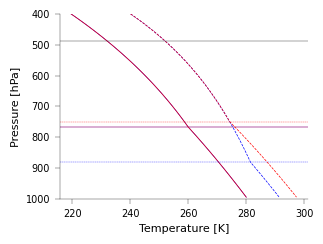

In [7]:
fig, ax = schematic_plot(temp_cold=280, sphum_cold=q_schematic * 0.5, temp_adiabat_change_cold=temp_a_change_schematic, 
                         r_change_cold=0.3, include_diff_plot=False)

### Changing adiabatic temperature anomaly
Here, it is obvious that if you warm one day more in the free troposphere than another, it will lead to more warming at the surface if nothing else is changed.

The surface warming is suppressed compared to free troposphere though, this is because the moist adiabatic lapse rate is smaller for the day that is warmed more.

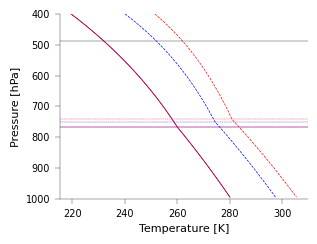

In [8]:
# Temp adiabat change - red line has larger change to adiabatic temperature
fig, ax = schematic_plot(temp_cold=280, sphum_cold=q_schematic * 0.5, temp_adiabat_change_cold=temp_a_change_schematic, 
                         temp_adiabat_change_hot=temp_a_change_schematic+10, include_diff_plot=False)

### Lapse Rate Comparison
The key to the schematics above is that there is a pressure interval where one day follows moist adiabat and one follows dry adiabat. Below I show that the gradient of the dry adiabat increases slightly with warming (becomes less steep in above figures) while the moist adiabatic lapse rate decreases (becomes more steep). It is this different lapse rate response to warming that is critical.

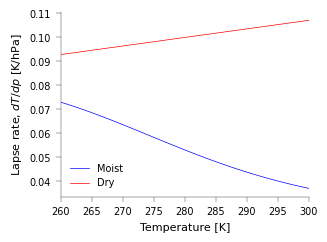

In [9]:
save_lapse_fig = False
lapse_plot_pressure = 800 * 100
lapse_plot_temp = np.linspace(260, 300, 50)
lapse_plot_z_coords = False

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if lapse_plot_z_coords:
    ax.plot(lapse_plot_temp, lapse_moist(lapse_plot_temp, lapse_plot_pressure) * 1000, color='b', label='Moist')
    ax.axhline(lapse_dry * 1000, color='r', label='Dry')
    ax.set_ylabel('Lapse rate, $-dT/dz [K/km]$')
else:
    ax.plot(lapse_plot_temp, lapse_moist(lapse_plot_temp, lapse_plot_pressure, True) * 100, color='b', label='Moist')
    ax.plot(lapse_plot_temp, lapse_dry * R * lapse_plot_temp / (lapse_plot_pressure * g) * 100, color='r', label='Dry')
    ax.set_ylabel('Lapse rate, $dT/dp$ [K/hPa]')
ax.legend()
ax.set_xlim(lapse_plot_temp[0], lapse_plot_temp[-1])
ax.set_xlabel('Temperature [K]')

if save_fig or save_lapse_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lapse_schematic.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Non-linear nature of $q^*$ Schematic
Solid line shows $q^*(T)$, dotted line shows $q^*(T+\epsilon)$ with $\epsilon=15K$.

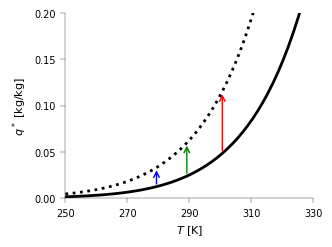

In [10]:
schematic_q_temp_values = np.linspace(250, 330, 50)
schematic_q_values = sphum_sat(schematic_q_temp_values, pressure_ft)             # use free troposphere pressure as illustrating temp adiabat
schematic_q_epsilon = 15
schematic_q_values_shift = sphum_sat(schematic_q_temp_values+schematic_q_epsilon, pressure_ft)

save_schematic_q_sat_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
ax.plot(schematic_q_temp_values, schematic_q_values, color='k', lw=2)
ax.plot(schematic_q_temp_values, schematic_q_values_shift, color='k', linestyle=':', lw=2)
ax.set_xlim(schematic_q_temp_values[0], schematic_q_temp_values[-1])
ax.set_ylabel('$q^*$ [kg/kg]')
ax.set_xlabel('$T$ [K]')
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.set_xticks([250, 270, 290, 310, 330])
ax.set_ylim(0, 0.2)
schematic_arrow_info = {'cold': [280, 'blue'], 'mean': [290, 'green'], 'hot': [300, 'red']}
for key in schematic_arrow_info:
    schematic_day_ind = np.argmin(np.abs(schematic_q_temp_values-schematic_arrow_info[key][0]))
    ax.annotate("", xy=(schematic_q_temp_values[schematic_day_ind], schematic_q_values[schematic_day_ind]), 
                xytext=(schematic_q_temp_values[schematic_day_ind], schematic_q_values_shift[schematic_day_ind]),
                arrowprops=dict(arrowstyle="<-", ec=schematic_arrow_info[key][1], lw=1))

if save_schematic_q_sat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/schematic_q_sat.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Scaling Factors for each term
Here I plot the scaling factor for each term as a function of near-surface conditions.

In [173]:
n_prefactor_temp = 100
n_prefactor_rh = 100
prefactor_plot_temp = np.linspace(270, 320, n_prefactor_temp)
prefactor_plot_rh = np.linspace(0, 1, n_prefactor_rh)
prefactor_plot_temp_adiabat = np.zeros((n_prefactor_temp, n_prefactor_rh))
prefactor_plot_sphum = np.zeros((n_prefactor_temp, n_prefactor_rh))
for i in range(n_prefactor_temp):
    for j in range(n_prefactor_rh):
        prefactor_plot_sphum[i, j] = sphum_sat(prefactor_plot_temp[i], pressure_surface)
        prefactor_plot_temp_adiabat[i, j] = get_temp_adiabat(prefactor_plot_temp[i], 
                                                             prefactor_plot_rh[j] * prefactor_plot_sphum[i, j],
                                                             pressure_surface, pressure_ft)

In [174]:
R_mod, _, _, beta_a1, beta_a2, _ = get_theory_prefactor_terms(prefactor_plot_temp_adiabat, pressure_surface, pressure_ft)
_, _, alpha_s, beta_s1, _, _ = get_theory_prefactor_terms(prefactor_plot_temp_adiabat, pressure_surface, pressure_ft,
                                                          prefactor_plot_sphum)
prefactor_temp_s = beta_a2/(beta_a1**2 * prefactor_plot_temp_adiabat) * (c_p-R_mod)
prefactor_sphum = (prefactor_temp_s/(c_p-R_mod) - alpha_s/beta_s1) * L_v
temp_s_anom_use = 5

Text(0, 0.5, 'Temperature, $\\overline{T_s}$ [K]')

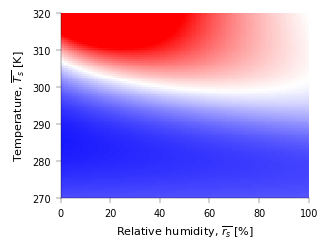

In [186]:
prefactor_plot_use_rh_anom = True
if prefactor_plot_use_rh_anom:
    # plot looks better if consider an RH anomaly rather than sphum anomaly
    sphum_anom_use = 0.1 * sphum_sat(prefactor_plot_temp, pressure_surface)[:, np.newaxis]
else:
    sphum_anom_use = 0.001
         
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
im = ax.pcolormesh(prefactor_plot_rh*100, prefactor_plot_temp, prefactor_sphum * sphum_anom_use, cmap='bwr', vmin=-0.07, vmax=0.07)
ax.set_xlim(prefactor_plot_rh[0]*100, prefactor_plot_rh[-1]*100)
ax.set_ylim(prefactor_plot_temp[0], prefactor_plot_temp[-1])
ax.set_xlabel('Relative humidity, $\overline{r_s}$ [%]')
ax.set_ylabel('Temperature, $\overline{T_s}$ [K]')

Text(0, 0.5, 'Temperature, $\\overline{T_s}$ [K]')

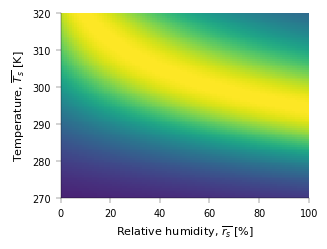

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
im = ax.pcolormesh(prefactor_plot_rh*100, prefactor_plot_temp, prefactor_temp_s * temp_s_anom_use, cmap='viridis', vmin=0, vmax=0.07)
ax.set_xlim(prefactor_plot_rh[0]*100, prefactor_plot_rh[-1]*100)
ax.set_ylim(prefactor_plot_temp[0], prefactor_plot_temp[-1])
ax.set_xlabel('Relative humidity, $\overline{r_s}$ [%]')
ax.set_ylabel('Temperature, $\overline{T_s}$ [K]')